# Exploratory Demo of All-types Functional Site Methods


*Goal:* infer prevalence of *all* functional genome sites that cannot be identified through individual knockouts (including both additive or epistatic sites).

**Outline:**
- Generate sample genome with both additive and redundant (epistatic) sites
- Inspect ground truth site counts in sample genome
- Generate repeat skeletonizations of sample genome (i.e., knockouts where no remaining sites can be removed without observing a fitness effect)
- Use mark-recapture statistics over "captures" of functional sites within skeletons to infer overall prevalence of functional sites


## Preliminaries


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from pylib.analyze_agnostic import assay_agnostic_naive
from pylib.analyze_epistasis import (
    describe_skeletons,
    skeletonize_naive,
)
from pylib.modelsys_explicit import GenomeExplicit
from pylib.modelsys_explicit import (
    GenomeExplicit,
    CalcKnockoutEffectsAdditive,
    CalcKnockoutEffectsEpistasis,
    create_additive_array,
    create_epistasis_matrix_disjoint,
    describe_additive_array,
    describe_epistasis_matrix,
)


Method implementations are organized as external Python source files within the local `pylib` directory.


In [2]:
np.random.seed(1234)


Ensure reproducibility.


## Create Sample Genome


Create a genome with 10,000 distinct sites.

Let 4% of sites have a knockout fitness effect below detectability threshold.
Effect sizes are distributed uniformly between 0 and 0.7, relative to the detectability threshold of 1.0.

Add 40 epistatic sets, each with 4 sites.
Fitness consequences of magnitudes between 0.7 and 1.6 occur when all sites within an epistatic set are knocked out.

Overlap is allowed --- n individual sites may have both additive and epistatic effects.


In [3]:
num_sites = 10000
distn = lambda x: np.random.rand(x) * 0.7
additive_array = create_additive_array(num_sites, 0.04, distn)
epistasis_matrix = create_epistasis_matrix_disjoint(num_sites, 40, 4)
genome = GenomeExplicit(
    [
        CalcKnockoutEffectsAdditive(additive_array),
        CalcKnockoutEffectsEpistasis(epistasis_matrix, effect_size=(0.7, 1.6)),
    ],
)


## Inspect Sample Genome


Create DataFrame with rows describing content of each genome site.


In [4]:
dfa = describe_additive_array(additive_array)
dfb = describe_epistasis_matrix(epistasis_matrix)
df_genome = pd.DataFrame.merge(dfa, dfb, on="site")
df_genome["site type"] = (
    df_genome["additive site"].astype(int)
    + df_genome["epistasis site"].astype(int) * 2
).map(
    {
        0: "neutral",
        1: "additive",
        2: "epistasis",
        3: "both",
    }
)

df_genome


,site,additive site,additive effect,epistasis site,num epistasis effects,site type
0,0,False,0.000000,False,0,neutral
1,1,True,0.049487,False,0,additive
2,2,True,0.396627,False,0,additive
3,3,False,0.000000,False,0,neutral
4,4,False,0.000000,False,0,neutral
...,...,...,...,...,...,...
9995,9995,False,0.000000,False,0,neutral
9996,9996,False,0.000000,False,0,neutral
9997,9997,False,0.000000,False,0,neutral
9998,9998,False,0.000000,False,0,neutral


How many of each kind of site are in the genome?


neutral      9445
additive      395
epistasis     155
both            5
Name: site type, dtype: int64

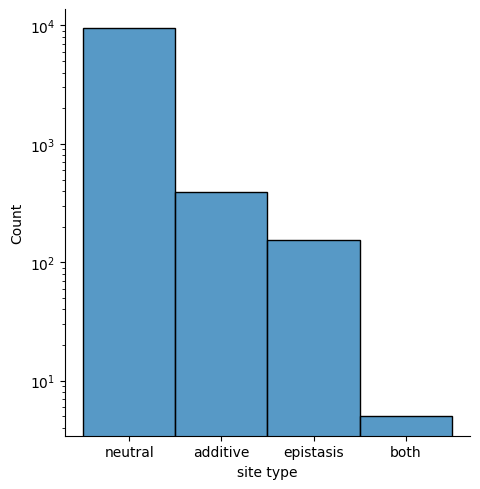

In [5]:
sns.displot(df_genome["site type"])
plt.yscale("log")
df_genome["site type"].value_counts()


How many functional (i.e., non-neutral) sites are there?


In [6]:
num_functional_sites = (df_genome["site type"] != "neutral").sum()
num_functional_sites


555

## Perform Skeletonizations


"Skeletons" are minimal sets of genome sites that maintain wile-type fitness.
Skeletons can be generated by sequentially removing sites from the genome, until no further sites can be removed without detectably reducing fitness.

Sample 5 skeletons.


In [7]:
num_skeletonizations = 5
skeletons = np.vstack(
    [
        skeletonize_naive(num_sites, genome.test_knockout)
        for _ in tqdm(range(num_skeletonizations))
    ],
)


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


Here is an example skeleton.


array([False,  True,  True, ..., False, False, False])

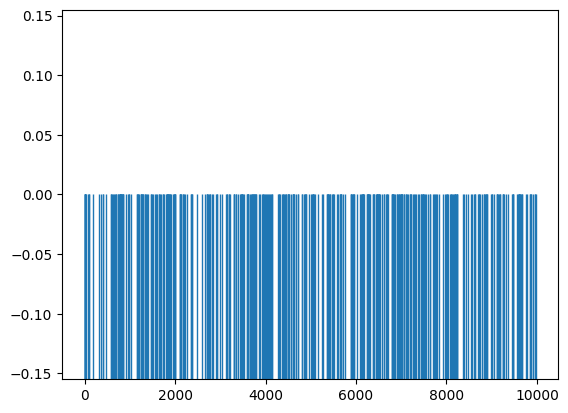

In [8]:
# convert from knockout true to retained true
retained_sites = ~skeletons[0].astype(bool)
sns.rugplot(
    np.flatnonzero(retained_sites),
    height=0.5,
)
retained_sites


## Describe Skeletons


Tabulate information across skeletons on a site-by-site basis.


In [9]:
df_skeletons = describe_skeletons(skeletons, genome.test_knockout)

df_skeletons


,site,"skeleton dose, excluded","skeleton dose std, excluded","skeleton dose ptp, excluded","skeleton exclusion order, excluded","skeleton exclusion order std, excluded","skeleton exclusion order ptp, excluded","skeleton outcome count, excluded","skeleton outcome frequency, excluded","skeleton dose, included",...,"skeleton outcome frequency, included",jackknife dose,jackknife dose std,jackknife dose ptp,raw jackknife result,raw jackknife result std,raw jackknife result ptp,jackknife result,jackknife result std,jackknife result ptp
0,0,9572.4,1.949359,5.0,6112.8,2598.985321,6445.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,9572.4,1.949359,5.0,1673.2,743.405475,1939.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,9572.4,1.949359,5.0,4427.4,2198.958003,5792.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,9572.4,1.949359,5.0,3214.2,2742.844363,7034.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,9572.4,1.949359,5.0,2921.8,2996.103920,7083.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9877,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.610976,0.000956,0.002268,1.610976,0.000956,0.002268
9996,9903,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.544390,0.000956,0.002268,1.544390,0.000956,0.002268
9997,9958,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.307906,0.000956,0.002268,1.307906,0.000956,0.002268
9998,9962,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.689130,0.000956,0.002268,1.689130,0.000956,0.002268


How many unique sites show up in any skeleton?
(i.e., num sites with direct evidence of functionality)


In [10]:
np.any(
    (~skeletons.astype(bool)),
    axis=0,
).sum()


504

## Estimate Number Functional Sites


The skeletonization process can actually be interpreted as a mark-recapture experiment.
Just like field researchers counting rabbits, we can estimate the total population of functional sites from the rate at which we "re-capture" specimens.
(Here, "re-capture" means that a site is included in more than one skeleton.)

Note that statistics taking into account bias in capture probability (aka "trap shyness") are necessary.
This implementation uses a nonparametric jackknife estimator due to Burnham and Overton (see source code for details).


In [11]:
assay_agnostic_naive(df_skeletons)


{'num sites estimate': 558.3499999999999,
 'num sites 95% CI': (533.2059805122569, 583.4940194877429)}

For comparison the actual number of functional sites is


In [12]:
num_functional_sites


555